# JHU covid-19 daily data processing 

Test and update functions for JHU data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta 
import datetime
import pytz
from tzwhere import tzwhere 
import JHUprocessing as jp


from matplotlib.dates import date2num       #-->Update

import matplotlib
from matplotlib import cm


# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# Load daily reports 

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0) 
    df = df.append(df_temp, sort=True) 

df.tail()

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Country_Region,Deaths,FIPS,Last Update,Last_Update,Lat,Latitude,Long_,Longitude,Province/State,Province_State,Recovered
2480,99.0,NaN,Venezuela,143.0,NaN,Venezuela,3.0,NaN,NaN,2020-04-01 21:58:34,6.423800,NaN,-66.589700,NaN,NaN,NaN,41.0
2481,155.0,NaN,Vietnam,218.0,NaN,Vietnam,0.0,NaN,NaN,2020-04-01 21:58:34,14.058324,NaN,108.277199,NaN,NaN,NaN,63.0
2482,115.0,NaN,West Bank and Gaza,134.0,NaN,West Bank and Gaza,1.0,NaN,NaN,2020-04-01 21:58:34,31.952200,NaN,35.233200,NaN,NaN,NaN,18.0
2483,36.0,NaN,Zambia,36.0,NaN,Zambia,0.0,NaN,NaN,2020-04-01 21:58:34,-13.133897,NaN,27.849332,NaN,NaN,NaN,0.0
2484,7.0,NaN,Zimbabwe,8.0,NaN,Zimbabwe,1.0,NaN,NaN,2020-04-01 21:58:34,-19.015438,NaN,29.154857,NaN,NaN,NaN,0.0


# adjust column names and use only relevant columns

In [4]:
# convert different datetimes to same datetime column 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   #  
cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 
df['Datetime']= pd.to_datetime(df['Last Update'] , unit='D'   ) 
df['Date'] = df['Datetime'].dt.date

cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 

cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 
 
col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered','Combined_Key' ]
df = df[col_order]

df.tail()

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key
2480,2020-04-01,Venezuela,NaN,99.0,143.0,3.0,41.0,Venezuela
2481,2020-04-01,Vietnam,NaN,155.0,218.0,0.0,63.0,Vietnam
2482,2020-04-01,West Bank and Gaza,NaN,115.0,134.0,1.0,18.0,West Bank and Gaza
2483,2020-04-01,Zambia,NaN,36.0,36.0,0.0,0.0,Zambia
2484,2020-04-01,Zimbabwe,NaN,7.0,8.0,1.0,0.0,Zimbabwe


# process columns 

In [5]:
bool_US = df['Country/Region'] =='US' 
# bool_last = df['Date'] > datetime.datetime(2020,3,22).date() 
bool_last = df['Date'] > datetime.datetime(2020,3,23).date()
 
df_US = df[bool_US & bool_last ].copy() 
 
df_US =  df_US.groupby(['Province/State','Date']).sum().reset_index()  
df_US = df_US.sort_values( by=['Province/State','Date']).reset_index(drop=True)  
 
df_US.head()
 

,Province/State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-24,0.0,242.0,0.0,0.0
1,Alabama,2020-03-25,0.0,381.0,1.0,0.0
2,Alabama,2020-03-26,0.0,517.0,1.0,0.0
3,Alabama,2020-03-27,0.0,587.0,4.0,0.0
4,Alabama,2020-03-28,0.0,694.0,4.0,0.0


# transform state geometry 

D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


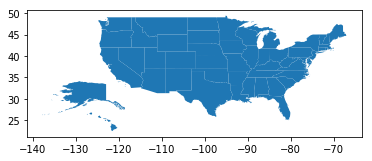

In [6]:
import geopandas as gpd

    
US = gpd.read_file( 'geo_data\states.shp')
AKratio = 0.4;  # scales Alaska 
HIratio = 1.3 # scales Hawai 
AKtrans = [25,-33] # moves Alaska south and east 
HItrans = [34,4] # moves Hawaii east and north 
 
import shapely.affinity as shp

# get original polygons
bool_alaska = US['STATE_NAME'] == 'Alaska'
alaska_geom = US.loc[bool_alaska,'geometry'].iloc[0] 

alaska_moved = shp.translate(alaska_geom, AKtrans[0], AKtrans[1])  
centroid = alaska_moved.centroid
alaska_scaled = shp.scale( alaska_moved, xfact=AKratio, yfact=AKratio, origin=centroid)
US['geometry'][50] =  alaska_scaled

bool_hawaii = US['STATE_NAME'] == 'Hawaii'
hawaii_geom = US.loc[bool_hawaii,'geometry'].iloc[0] 

hawaii_moved = shp.translate(hawaii_geom, HItrans[0], HItrans[1])  
centroid = hawaii_moved.centroid
hawaii_scaled = shp.scale( hawaii_moved, xfact=HIratio, yfact=HIratio, origin=centroid)
US['geometry'][0] =  hawaii_scaled

  
 
US.plot()
 

In [7]:
US.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-127.1978117763681 26.5332963381391...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


In [8]:
();

df_US

#     bool_US = US['STATE_NAME'] == state 
# #     US.loc[bool_US,'Cases'] = latest_cases  
#     US.loc[bool_US,'Cases'] = np.log(latest_cases+1) 

US.head()



# states = US['STATE_NAME'].tolist()
states = df_US['Province/State'].unique().tolist()
dates = df_US['Date'].unique() 

for state in states: 
#     print(state)
    bool_state = df_US['Province/State'] == state 
    bool_date = df_US['Date'] == dates[-1]
    bool_prior = df_US['Date'] == dates[-7] 
    if (bool_state & bool_date).sum() > 0:
        now_cases = df_US[bool_state & bool_date ]['Confirmed'].iloc[0]
        prior_cases = df_US[bool_state & bool_prior ]['Confirmed'].iloc[0]
        latest_cases = (now_cases-prior_cases)/7
    else:
        latest_cases = 0 
         
    df_US.loc[bool_state ,'Cases'] = np.log(latest_cases + 2)
    
    
# US['Cases'] = 0 
df_US = df_US.rename(columns={'Province/State':'STATE_NAME'}) 

df_US = df_US[bool_date] 
US= pd.merge(US, df_US, how='left', on=['STATE_NAME'])
df_US.head()  

,STATE_NAME,Date,Active,Confirmed,Deaths,Recovered,Cases
8,Alabama,2020-04-01,0.0,1060.0,27.0,0.0,4.376655
17,Alaska,2020-04-01,0.0,132.0,3.0,0.0,2.553900
33,Arizona,2020-04-01,0.0,1530.0,29.0,0.0,4.997212
42,Arkansas,2020-04-01,0.0,584.0,10.0,0.0,3.626244
51,California,2020-04-01,0.0,9399.0,199.0,0.0,6.669135


# plot US map

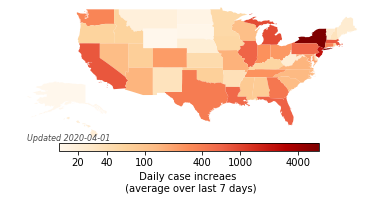

In [15]:
# fig, ax = plt.subplots(1,1 ,figsize=(15,8))
fig, ax = plt.subplots(1,1 ,figsize=half_w )


wp = US.plot(column='Cases', ax=ax, cmap='OrRd'   );

wp.set_xbound(-135,-66)
wp.set_ybound(20,49.5)  
 

vmin =    US['Cases'].min()
vmax =  ( US['Cases'].max() )
 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
 



# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = fig.add_axes([0.2, 0.25, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
 

# tick_array =  [1,10,100,1000,10000,10000] 
tick_array =  [20,40,100,400,1000,4000,10000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')

ax.axis("off")


ax.annotate('Updated '+str( df_US['Date'].iloc[-1]), 
            [-135,22 ], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_map'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )   